# Notebook 03 - EDA

The purpose of this notebook is to perform an in-depth Exploratory Data Analysis (EDA) on the cleaned dataset stored in the Silver layer. This stage focuses on understanding the statistical behavior, distributions, correlations, and separability of features between benign and attack traffic.

In this notebook, we will:

- Load the cleaned and consolidated dataset from the Silver layer
- Explore summary statistics and feature distributions
- Analyze class balance and attack-type frequency
- Visualize key numerical features, comparing benign vs. attack behavior
- Identify highly correlated features and potential multicollinearity
- Inspect patterns in temporal, packet-level, and flow-level variables
- Document insights that will guide feature selection, normalization, and future modeling steps

This notebook does not modify or clean the data. Its purpose is to extract meaningful insights that support decision-making in preprocessing and model development.

# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, f_oneway, kruskal
import random
from pathlib import Path

# Load Silver data

In [3]:
silver_path = Path("../data/silver/data_merge_and_cleaned.csv")

# Check if file exists
if not silver_path.exists():
    raise FileNotFoundError(f"File not found: {silver_path}")
else:
    print(f"Loading dataset from: {silver_path}")

df = pd.read_csv(silver_path)

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns\n")

# Show first 5 rows
df.head()

Loading dataset from: ..\data\silver\data_merge_and_cleaned.csv

Dataset loaded successfully!
Shape: 3,276,133 rows × 86 columns



,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Name,Label,source_file
0,34.173.20.6-192.168.137.234-443-58644-6,34.173.20.6,443.0,192.168.137.234,58644.0,6.0,2023-09-14 09:24:26,14746364.0,6.0,0.0,...,0.0,0.0,0.0,14681116.0,0.000000,14681116.0,14681116.0,Benign Traffic,0,Benign Traffic.csv
1,34.173.20.6-192.168.137.234-443-58646-6,34.173.20.6,443.0,192.168.137.234,58646.0,6.0,2023-09-14 09:24:41,60102110.0,18.0,0.0,...,0.0,219123.0,219123.0,14957706.0,190543.248665,15061923.0,14672051.0,Benign Traffic,0,Benign Traffic.csv
2,52.40.210.103-192.168.137.40-18665-60378-6,52.40.210.103,18665.0,192.168.137.40,60378.0,6.0,2023-09-14 09:24:14,90106769.0,9.0,0.0,...,0.0,582529.0,582529.0,29841412.0,319090.538141,30049066.0,29473997.0,Benign Traffic,0,Benign Traffic.csv
3,10.0.0.3-10.0.0.254-44505-1883-6,10.0.0.3,44505.0,10.0.0.254,1883.0,6.0,2023-09-14 09:24:15,119998980.0,123.0,123.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign Traffic,0,Benign Traffic.csv
4,10.0.0.7-10.0.0.254-45727-1883-6,10.0.0.7,45727.0,10.0.0.254,1883.0,6.0,2023-09-14 09:24:15,119998539.0,123.0,123.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign Traffic,0,Benign Traffic.csv


# Basic Stats

In [3]:
pd.set_option('display.max_rows', None) # show all rows
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.width', None)   # set no limit on display width
pd.set_option('display.max_colwidth', None) # set no limit on column width

print("Dataset Information\n")
df.info()

print("\nBasic Statistical Summary\n")
display(df.describe().T)

print("\nExtended Statistical Summary (1%, 5%, 95%, 99%)\n")
percentiles = df.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).T
display(percentiles)

print("\nMissing Values per Column\n")
missing = df.isna().sum().sort_values(ascending=False)
display(missing)

print("\nData Types Summary\n")
dtype_summary = df.dtypes.value_counts()
display(dtype_summary)

print("\nUnique Values per Categorical Column\n")
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276133 entries, 0 to 3276132
Data columns (total 86 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Flow ID                     object 
 1   Src IP                      object 
 2   Src Port                    float64
 3   Dst IP                      object 
 4   Dst Port                    float64
 5   Protocol                    float64
 6   Timestamp                   object 
 7   Flow Duration               float64
 8   Total Fwd Packet            float64
 9   Total Bwd packets           float64
 10  Total Length of Fwd Packet  float64
 11  Total Length of Bwd Packet  float64
 12  Fwd Packet Length Max       float64
 13  Fwd Packet Length Min       float64
 14  Fwd Packet Length Mean      float64
 15  Fwd Packet Length Std       float64
 16  Bwd Packet Length Max       float64
 17  Bwd Packet Length Min       float64
 18  Bwd Packet Length Mean      float64
 19  

,count,mean,std,min,25%,50%,75%,max
Src Port,3276133.0,2.903135e+04,2.064989e+04,0.000000e+00,8200.000000,2.952900e+04,4.720100e+04,6.553500e+04
Dst Port,3276133.0,1.989518e+04,2.166041e+04,1.000000e+00,6668.000000,6.668000e+03,4.518400e+04,6.548700e+04
Protocol,3276133.0,6.000000e+00,0.000000e+00,6.000000e+00,6.000000,6.000000e+00,6.000000e+00,6.000000e+00
Flow Duration,3276133.0,6.181155e+07,5.426641e+07,0.000000e+00,293954.000000,7.393189e+07,1.184153e+08,1.200000e+08
Total Fwd Packet,3276133.0,1.654218e+01,8.352497e+01,1.000000e+00,2.000000,9.000000e+00,3.000000e+01,3.187200e+04
Total Bwd packets,3276133.0,2.120539e+00,6.795506e+01,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,9.890000e+03
Total Length of Fwd Packet,3276133.0,7.333979e+02,6.214519e+04,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.614014e+07
Total Length of Bwd Packet,3276133.0,4.577148e+02,3.601600e+04,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.389573e+07
Fwd Packet Length Max,3276133.0,1.814461e+01,1.520210e+02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.460000e+03
Fwd Packet Length Min,3276133.0,4.407090e+00,6.407261e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.460000e+03



Extended Statistical Summary (1%, 5%, 95%, 99%)



,count,mean,std,min,1%,5%,50%,95%,99%,max
Src Port,3276133.0,2.903135e+04,2.064989e+04,0.000000e+00,311.000000,1600.000000,2.952900e+04,6.118800e+04,6.466500e+04,6.553500e+04
Dst Port,3276133.0,1.989518e+04,2.166041e+04,1.000000e+00,1883.000000,1883.000000,6.668000e+03,5.898400e+04,6.224900e+04,6.548700e+04
Protocol,3276133.0,6.000000e+00,0.000000e+00,6.000000e+00,6.000000,6.000000,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00
Flow Duration,3276133.0,6.181155e+07,5.426641e+07,0.000000e+00,0.000000,9566.000000,7.393189e+07,1.194848e+08,1.197914e+08,1.200000e+08
Total Fwd Packet,3276133.0,1.654218e+01,8.352497e+01,1.000000e+00,1.000000,1.000000,9.000000e+00,4.200000e+01,4.400000e+01,3.187200e+04
Total Bwd packets,3276133.0,2.120539e+00,6.795506e+01,0.000000e+00,0.000000,0.000000,0.000000e+00,3.000000e+00,2.000000e+01,9.890000e+03
Total Length of Fwd Packet,3276133.0,7.333979e+02,6.214519e+04,0.000000e+00,0.000000,0.000000,0.000000e+00,1.700000e+01,3.706000e+03,4.614014e+07
Total Length of Bwd Packet,3276133.0,4.577148e+02,3.601600e+04,0.000000e+00,0.000000,0.000000,0.000000e+00,4.000000e+00,4.936000e+03,1.389573e+07
Fwd Packet Length Max,3276133.0,1.814461e+01,1.520210e+02,0.000000e+00,0.000000,0.000000,0.000000e+00,1.700000e+01,1.444000e+03,1.460000e+03
Fwd Packet Length Min,3276133.0,4.407090e+00,6.407261e+01,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.460000e+03



Missing Values per Column



Flow ID                       0
Src IP                        0
Src Port                      0
Dst IP                        0
Dst Port                      0
Protocol                      0
Timestamp                     0
Flow Duration                 0
Total Fwd Packet              0
Total Bwd packets             0
Total Length of Fwd Packet    0
Total Length of Bwd Packet    0
Fwd Packet Length Max         0
Fwd Packet Length Min         0
Fwd Packet Length Mean        0
Fwd Packet Length Std         0
Bwd Packet Length Max         0
Bwd Packet Length Min         0
Bwd Packet Length Mean        0
Bwd Packet Length Std         0
Flow Bytes/s                  0
Flow Packets/s                0
Flow IAT Mean                 0
Flow IAT Std                  0
Flow IAT Max                  0
Flow IAT Min                  0
Fwd IAT Total                 0
Fwd IAT Mean                  0
Fwd IAT Std                   0
Fwd IAT Max                   0
Fwd IAT Min                   0
Bwd IAT 


Data Types Summary



float64    79
object      6
int64       1
Name: count, dtype: int64


Unique Values per Categorical Column

Flow ID: 1055241 unique values
Src IP: 406 unique values
Dst IP: 354 unique values
Timestamp: 25527 unique values
Attack Name: 15 unique values
source_file: 15 unique values


In [4]:
pd.reset_option('display.max_rows') # reset to default
pd.reset_option('display.max_columns') 
pd.reset_option('display.width')   
pd.reset_option('display.max_colwidth') 

# Class Distribution (Benign vs Attack)

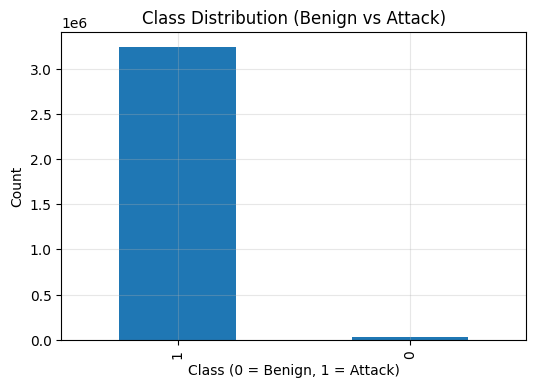


Class distribution:
Label
1    3243527
0      32606
Name: count, dtype: int64


In [5]:
plt.figure(figsize=(6,4))
df['Label'].value_counts().plot(kind='bar')
plt.title("Class Distribution (Benign vs Attack)")
plt.xlabel("Class (0 = Benign, 1 = Attack)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

print("\nClass distribution:")
print(df['Label'].value_counts())

The dataset shows a **severe class imbalance**, with more than 3,240,000 attack samples and only ~32,000 benign samples.  
This means that **attacks dominate the dataset by a ratio of almost 100:1**.

Such imbalance can strongly bias machine learning models, causing them to:

- Learn to predict “attack” for most inputs and still achieve high accuracy  
- Fail to properly recognize benign traffic  
- Produce misleading evaluation metrics (accuracy becomes unreliable)  
- Overfit to majority‐class patterns and ignore minority‐class behavior  

# Histogram Visualizations per group of and individual feature

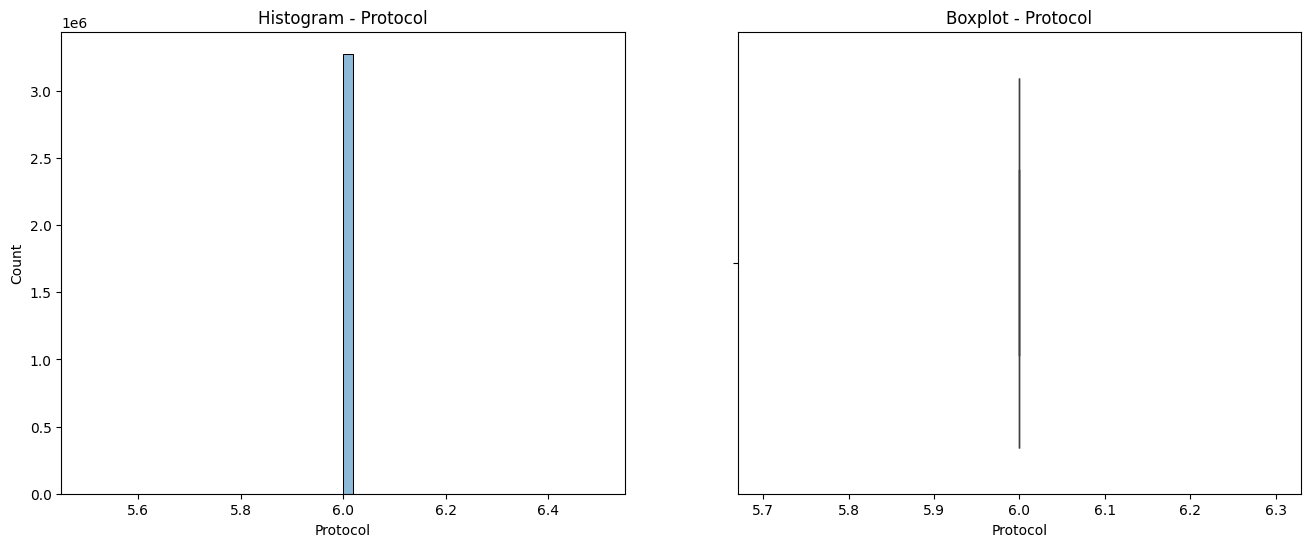

In [11]:
def plot_feature_distribution(df, col):
    plt.figure(figsize=(16, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Histogram - {col}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot - {col}")

    plt.show()

plot_feature_distribution(df, "Protocol")


In [7]:
# per group of features

# 1. Packet Size Features
packet_size_features = [
    "Packet Length Min", "Packet Length Max", "Packet Length Mean",
    "Packet Length Std", "Packet Length Variance",
    "Total Length of Fwd Packet", "Total Length of Bwd Packet",
    "Fwd Packet Length Max", "Fwd Packet Length Min", "Fwd Packet Length Mean", "Fwd Packet Length Std",
    "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", "Bwd Packet Length Std",
    "Average Packet Size", "Fwd Segment Size Avg", "Bwd Segment Size Avg"
]

# 2. IAT (Inter-Arrival Time) Features
iat_features = [
    "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min",
    "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min",
    "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min"
]

# 3. Flow Features
flow_features = [
    "Flow Duration", "Flow Bytes/s", "Flow Packets/s",
    "Fwd Packets/s", "Bwd Packets/s", "Down/Up Ratio"
]

# 4. TCP Flag Features
flag_features = [
    "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags",
    "FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count",
    "ACK Flag Count", "URG Flag Count", "CWR Flag Count", "ECE Flag Count"
]

# 5. TCP Window & Headers
window_header_features = [
    "FWD Init Win Bytes", "Bwd Init Win Bytes",
    "Fwd Header Length", "Bwd Header Length"
]

# 6. Activity Features
activity_features = [
    "Active Mean", "Active Std", "Active Max", "Active Min",
    "Idle Mean", "Idle Std", "Idle Max", "Idle Min"
]

# 7. Subflow Features
subflow_features = [
    "Subflow Fwd Packets", "Subflow Fwd Bytes",
    "Subflow Bwd Packets", "Subflow Bwd Bytes"
]

In [2]:
def pairplot_group(df, features, sample_size=5000, title="Pairplot"):
    """
    Draws a pairplot for a group of related features.
    Sampling is used to prevent memory overload.
    """

    # Filter only numeric & present columns
    valid_features = [col for col in features if col in df.columns]

    if len(valid_features) < 2:
        print(f" Not enough valid features for: {title}")
        return

    # Sample for speed
    df_sample = df[valid_features + ["Label"]].sample(
        min(sample_size, len(df)), 
        random_state=42
    )

    print(f" Generating pairplot for: {title} with {len(valid_features)} features")

    sns.pairplot(
        df_sample,
        vars=valid_features,
        hue="Label",
        diag_kind="kde",
        plot_kws={"alpha": 0.5, "s": 10}
    )

    plt.suptitle(title, fontsize=18)
    plt.show()

 Generating pairplot for: Flow Features with 6 features


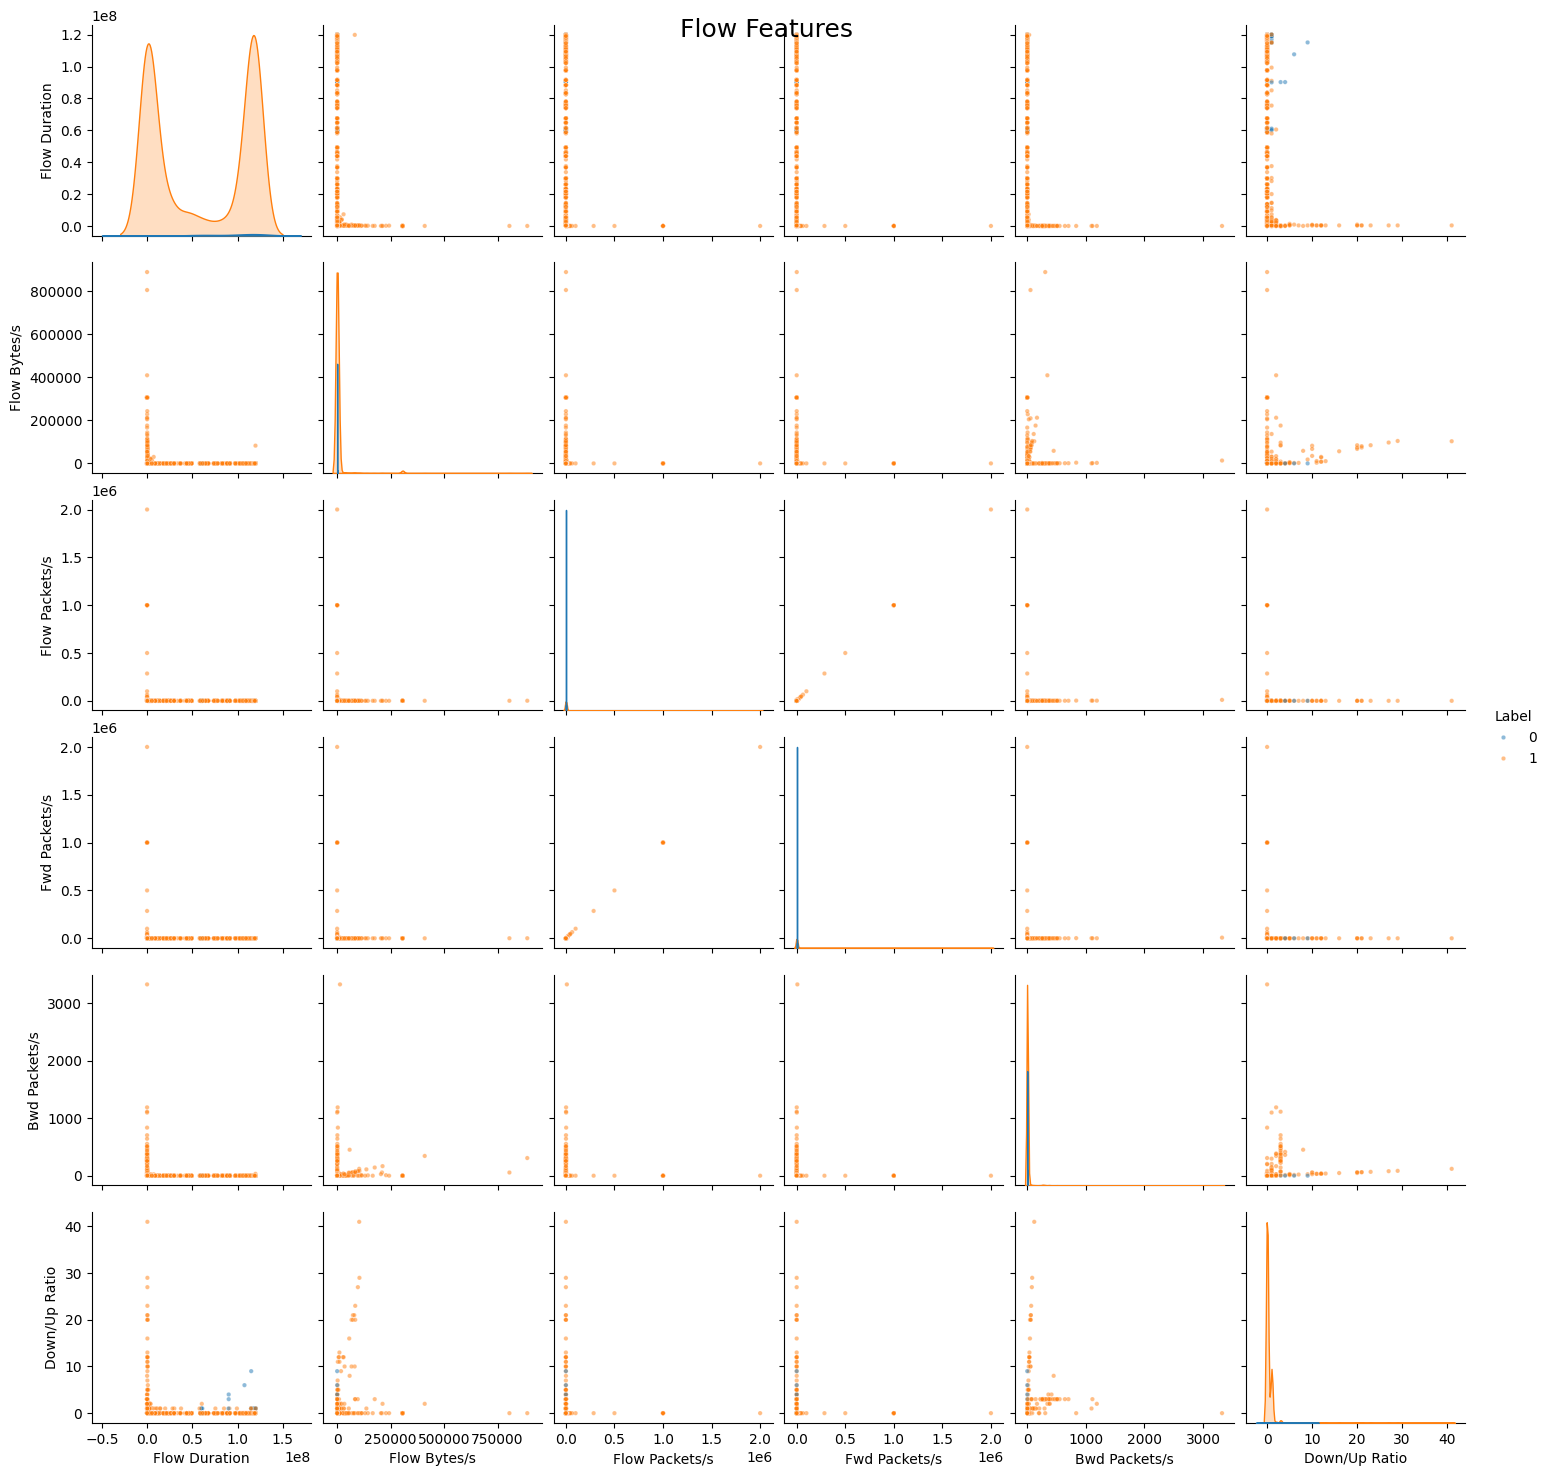

In [8]:
pairplot_group(df, flow_features, title="Flow Features")

# Statistic tests

In [6]:
# Select only numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude Label if necessary
numeric_cols = [c for c in numeric_cols if c != "Label"]

# List of classes (15 attack types + benign)
classes = df["Attack Name"].unique().tolist()

# Dictionaries to store results
normality_results = {}
stats_results = {}

def ks_normality_test(series):
    """Kolmogorov–Smirnov normality test"""
    series = series.dropna()

    if series.std() == 0:
        return 1.0  # no variance = treated as non-significant (high p-value)

    series_std = (series - series.mean()) / series.std()

    stat, p = kstest(series_std, "norm")
    return p

def anova_test(df, col):
    """One-Way ANOVA for normal variables"""
    groups = [df[df["Attack Name"] == cl][col].dropna() for cl in classes]
    stat, p = f_oneway(*groups)
    return p

def kruskal_test(df, col):
    """Kruskal–Wallis test for non-normal variables"""
    groups = [df[df["Attack Name"] == cl][col].dropna() for cl in classes]
    stat, p = kruskal(*groups)
    return p

print("Running normality and class-comparison tests...\n")

for col in numeric_cols:

    # Normality test
    p_norm = ks_normality_test(df[col])
    is_normal = p_norm > 0.05

    normality_results[col] = {
        "p_normality": p_norm,
        "normal": is_normal
    }

    # Select appropriate statistical test
    if is_normal:
        p_stat = anova_test(df, col)
        test_used = "ANOVA"
    else:
        p_stat = kruskal_test(df, col)
        test_used = "Kruskal–Wallis"

    stats_results[col] = {
        "test_used": test_used,
        "p_value": p_stat,
        "significant": p_stat < 0.05
    }

print("Tests completed.\n")

Running normality and class-comparison tests...



c:\Users\User\Documents\UdeA\Redes II\Proyecto_final\AttackScan-IDS\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


Tests completed.



In [7]:
result_table = pd.DataFrame({       
    "Feature": numeric_cols,
    "Normal": [normality_results[c]["normal"] for c in numeric_cols],
    "p_Normality": [normality_results[c]["p_normality"] for c in numeric_cols],
    "Test Used": [stats_results[c]["test_used"] for c in numeric_cols],
    "p_Value": [stats_results[c]["p_value"] for c in numeric_cols],
    "Significant": [stats_results[c]["significant"] for c in numeric_cols],
})

result_table.sort_values("p_Value", inplace=True)

# normal and non-normal features
normal_features = [c for c in numeric_cols if normality_results[c]["normal"]]
non_normal_features = [c for c in numeric_cols if not normality_results[c]["normal"]]

# Randomly select one from each category
random_normal = random.choice(normal_features) if normal_features else "None"
random_non_normal = random.choice(non_normal_features) if non_normal_features else "None"


print("Selected features for visualization:\n")
print(f"Random normally-distributed feature: {random_normal}")
print(f"Random non-normal feature: {random_non_normal}\n")

# Normality counts
print("Normality summary:")
print(f"Normal features: {len(normal_features)}")
print(f"Non-normal features: {len(non_normal_features)}\n")

# Non significant features

non_significant_features = result_table[result_table["Significant"] == False]["Feature"].tolist()

print("Features without significant differences among classes:\n")
for f in non_significant_features:
    print(" -", f)

print("\nTotal non-significant features:", len(non_significant_features), "\n")

Selected features for visualization:

Random normally-distributed feature: Bwd URG Flags
Random non-normal feature: Fwd URG Flags

Normality summary:
Normal features: 6
Non-normal features: 73

Features without significant differences among classes:

 - Protocol
 - Bwd PSH Flags
 - Bwd URG Flags
 - Fwd Bytes/Bulk Avg
 - Fwd Packet/Bulk Avg
 - Fwd Bulk Rate Avg

Total non-significant features: 6 



# Correlation Matrix & Multicollinearity

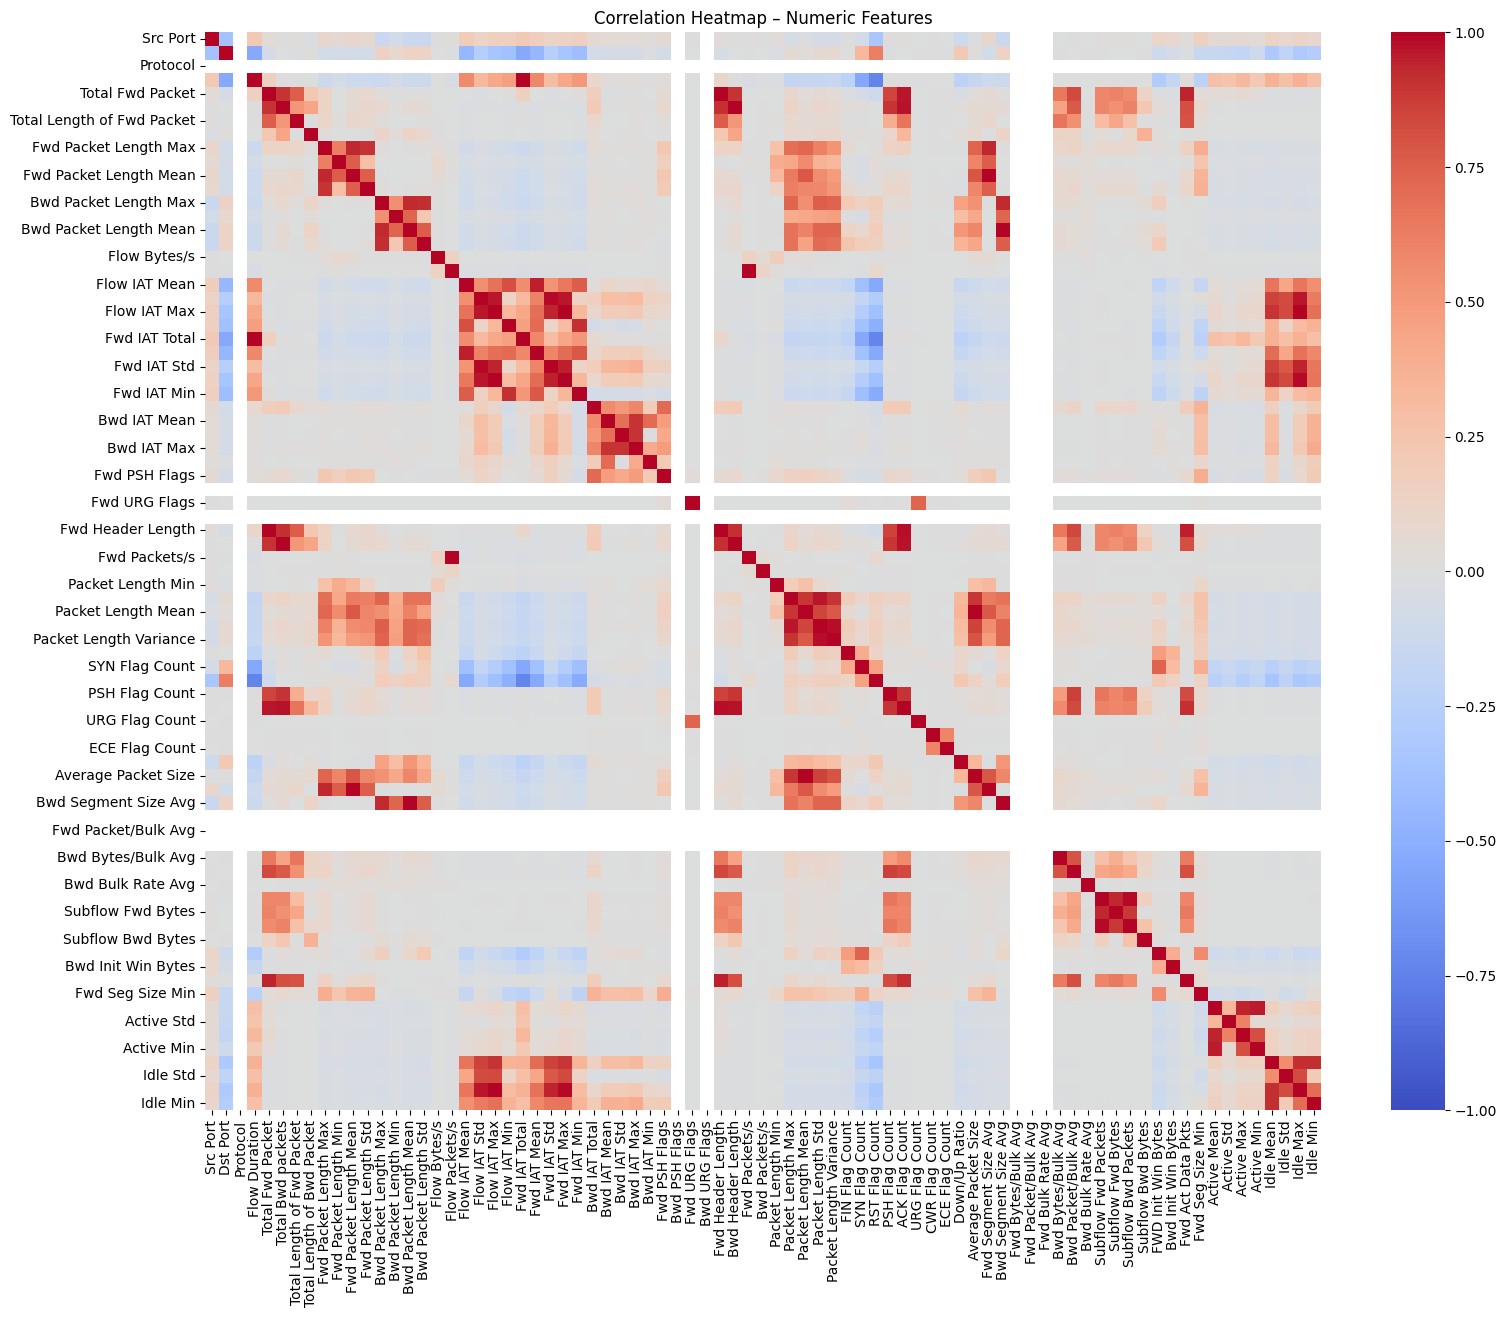

In [11]:
plt.figure(figsize=(18,14))
sns.heatmap(
    df[numeric_cols].corr(),
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1
)
plt.title("Correlation Heatmap – Numeric Features")
plt.show()

In [12]:
corr_matrix = df[numeric_cols].corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if isinstance(upper.loc[row, col], float) and upper.loc[row, col] > 0.90
]

print("Highly correlated feature pairs (|corr| > 0.90):")
for a,b,c in high_corr_pairs:
    print(f"{a} <--> {b} | corr = {c:.3f}")

print("\nTotal highly correlated pairs:", len(high_corr_pairs))

Highly correlated feature pairs (|corr| > 0.90):
Total Bwd packets <--> Total Fwd Packet | corr = 0.902
Fwd Packet Length Mean <--> Fwd Packet Length Max | corr = 0.931
Fwd Packet Length Std <--> Fwd Packet Length Max | corr = 0.902
Bwd Packet Length Mean <--> Bwd Packet Length Max | corr = 0.925
Bwd Packet Length Std <--> Bwd Packet Length Max | corr = 0.921
Flow IAT Max <--> Flow IAT Std | corr = 0.963
Fwd IAT Total <--> Flow Duration | corr = 0.998
Fwd IAT Mean <--> Flow IAT Mean | corr = 0.948
Fwd IAT Std <--> Flow IAT Std | corr = 0.987
Fwd IAT Std <--> Flow IAT Max | corr = 0.943
Fwd IAT Max <--> Flow IAT Std | corr = 0.964
Fwd IAT Max <--> Flow IAT Max | corr = 0.995
Fwd IAT Max <--> Fwd IAT Std | corr = 0.947
Fwd IAT Min <--> Flow IAT Min | corr = 0.913
Bwd IAT Max <--> Bwd IAT Mean | corr = 0.901
Fwd Header Length <--> Total Fwd Packet | corr = 0.998
Fwd Header Length <--> Total Bwd packets | corr = 0.911
Bwd Header Length <--> Total Fwd Packet | corr = 0.902
Bwd Header Length

## Interpretation of Multicollinearity Findings

The correlation analysis revealed several groups of highly redundant features:

### A) Backward Packet Size / IAT Redundant Cluster
Includes features such as:
- Bwd Packet Length Mean, Max, Std
- Bwd Segment Size Avg
- Bwd IAT Mean, Max, Std, Total

These variables express the same physical behavior: *packet size and timing in the backward direction*.
We keep:
- **Bwd Packet Length Mean**
- **Bwd IAT Mean**

The rest are redundant.

### B) Forward Packet Size / IAT Redundant Cluster
Includes:
- Fwd Packet Length Mean, Max, Std
- Fwd Segment Size Avg
- Fwd IAT Mean, Max, Std, Total

We keep:
- **Fwd Packet Length Mean**
- **Fwd IAT Mean**

### C) Packet Length Set (Variance, Std, Max, Mean, Average Packet Size)
All >0.99 correlated.

We keep:
- **Packet Length Mean**

### D) Flags
PSH, ACK, SYN, RST have the strongest discriminative ability.
We keep the core flags:
- **SYN**, **ACK**, **RST**, **URG**

And drop others with no value.

### E) Active / Idle
We keep:
- **Active Mean**
- **Idle Mean**

These represent the core behavior of connection activity/inactivity.

These decisions optimize the feature space for modeling by eliminating noise and redundancy.


# TimeStamp Analysis

<Figure size 1000x500 with 0 Axes>

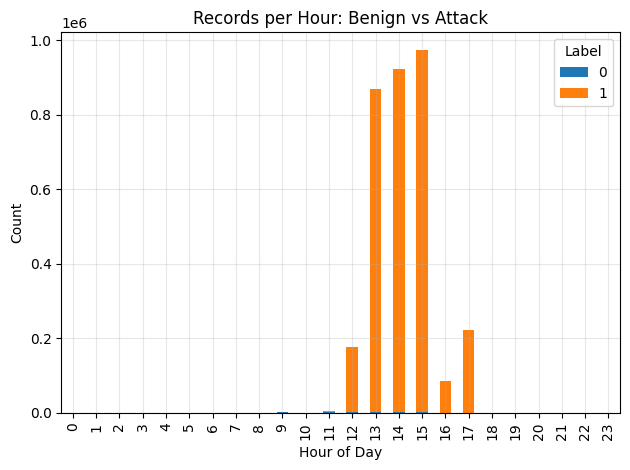

<Figure size 1600x600 with 0 Axes>

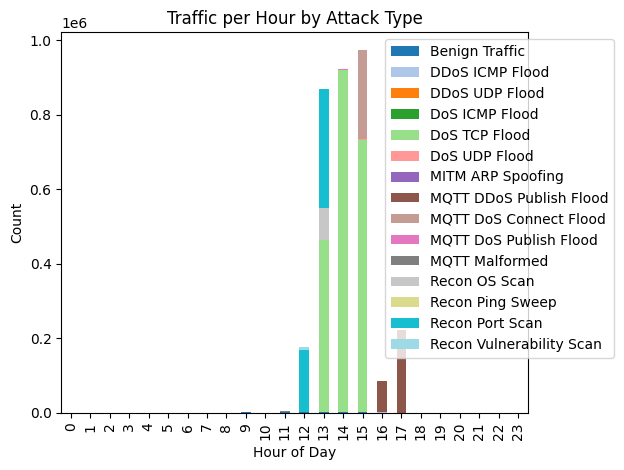

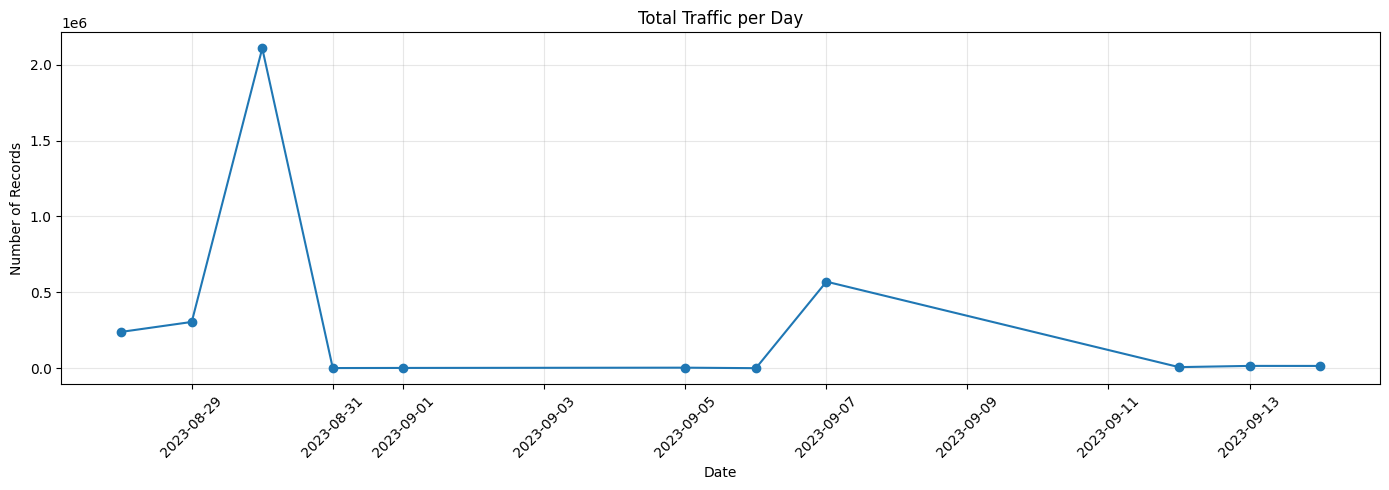

In [16]:
# Ensure Timestamp is datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# Extract hour
df["hour"] = df["Timestamp"].dt.hour

plt.figure(figsize=(10,5))
df.groupby(['hour', 'Label']).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.title("Records per Hour: Benign vs Attack")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,6))
df.groupby(['hour', 'Attack Name']).size().unstack(fill_value=0).plot(
    kind='bar', stacked=True, colormap='tab20'
)
plt.title("Traffic per Hour by Attack Type")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

df['date'] = pd.to_datetime(df['Timestamp']).dt.date
traffic_per_day = df.groupby('date').size()

plt.figure(figsize=(14,5))
traffic_per_day.plot(kind='line', marker='o')
plt.title("Total Traffic per Day")
plt.xlabel("Date")
plt.ylabel("Number of Records")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Summary of this stage

The dataset shows strong class imbalance, dominated by DoS-type attacks.  
Attacks are concentrated between **1 PM and 3 PM**, likely due to higher normal traffic volume during that time, which helps conceal malicious patterns.  
No clear daily pattern exists.

The statistical tests and correlation analysis revealed:

- A large number of features do not show statistical significance between classes.
- Many variables are highly redundant due to multicollinearity (> 0.90).
- Core packet behavior can be represented with a small subset of meaningful features.

**For preprocessing, we will keep only the essential, non-redundant, and discriminative features:**

- Packet behavior features: `Fwd Packet Length Mean`, `Bwd Packet Length Mean`
- Temporal behavior features: `Fwd IAT Mean`, `Bwd IAT Mean`
- Global packet size descriptor: `Packet Length Mean`
- Activity indicators: `Active Mean`, `Idle Mean`
- TCP flags: `SYN`, `ACK`, `RST`, `URG`
- Destination IP (important for identifying repeated targets)
- Port features (`Src Port`, `Dst Port`)
- Flow-level counts (Subflow stats, Total Fwd/Bwd Packet)

These features will form the basis of the **Gold-preprocessed dataset**.
